In [18]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})    


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
t_0 = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr

σ_eq = 0.005
ρ_m = 4e19                #ρ_m = 4e19 M☉ Gpc^-3


m_1 = 7   #in units of M☉
m_2 = 9  #in units of M☉

y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy = (y_2-y_1)


y_list = np.zeros(15)

for i in range(len(y_list)):
    y_list[i] = (y_1 + (i*dy))
    

M_1_list = np.zeros(len(y_list))
M_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i] = (np.ceil(np.exp(y)))
    M_2_list[i] = (np.ceil(np.exp(y)))
    

            
m_1_list = [int(M_1) for M_1 in M_1_list]
m_2_list = [int(M_2) for M_2 in M_2_list]

    
Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy)
    Δ_2_list[i] = np.exp(y + 0.5*dy) - np.exp(y - 0.5*dy) 
    
    
        
m_2 = 0.1        # m_1 = 1 solar mass
a_i = 1e10     # in units of pc


print("m_1 =", m_1_list)    

m_1 = [7, 10, 12, 15, 20, 25, 32, 41, 53, 68, 87, 112, 143, 184, 237]


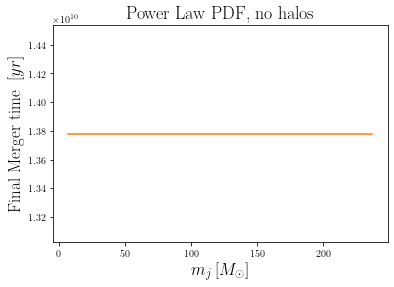

In [19]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


def final_merger_time_nohalos(m_1):  # assuming a_i = a_f and hence j_i = j_f .
    a_f = a_i
    t_initial_merger_time = t_m
    return np.sqrt(a_f/a_i) * t_initial_merger_time



final_merger_time_nohalos_list = np.zeros(len(m_2_list))

for i, m_1 in enumerate(m_1_list):
    final_merger_time_nohalos_list[i] = final_merger_time_nohalos(m_2)

plt.plot(m_1_list, final_merger_time_nohalos_list, 'C1')



plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 17)
plt.title('Power Law PDF, no halos', fontsize = 18)
plt.show()     

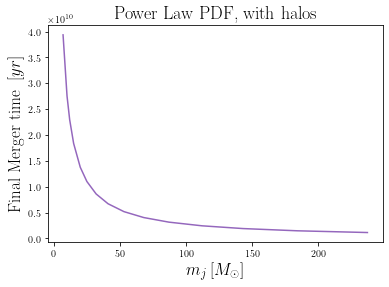

In [20]:

def final_merger_time_withhalos(m_1):  # j_f = sqrt(a_i/a_f) * j_i
    
    t_initial_merger_time = t_m  # as per j_i corresponding to t_m.
    
    def x(m_1, m_2):  # Let a_i = (0.0977 * λ *x)
        return  (((3 * (m_1 + m_2 ) * a_i)/(8 * π * ρ_eq))**(1/4)) * ((0.0977)**(-1/4))
    
    def λ(m_1, m_2):
        return (a_i / (0.0977 * x(m_1, m_2)))
    
    
    def s(m_1, m_2): # S_dec of the binary decouple.
        return ((0.03095*λ(m_1, m_2)+ 0.3425)*λ(m_1, m_2))
    
    
    def t_dec(m_1, m_2):    # t_dec of the binary decouple.
        return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2)-2)*np.sqrt(s(m_1, m_2)+1))+(4/3)))
  
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    
    
    def M_1halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_1)*((2*G*m_1*(t_dec(m_1, m_2)**2))**(1/4)))
    
    
    def M_2halo(m_1, m_2):
        return (((16*π)/3)*ρ_bar(m_2)*((2*G*m_2*(t_dec(m_1, m_2)**2))**(1/4)))
    

    def M_binary_initial(m_1, m_2):
        return (m_1 + m_2 + M_1halo(m_1, m_2) + M_2halo(m_1, m_2))
      
    def M_1(m_1, m_2):
        return (m_1 + M_1halo(m_1, m_2))
    
    def M_2(m_1, m_2):
        return (m_2 + M_2halo(m_1, m_2))
    
    def M_binary_final(m_1, m_2):
        return (m_1 + m_2 )
      
    
    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m): 
        return ((2*G*m*(t_dec(m_1, m_2)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m))**(1/2))-((r_s(m))**(1/2)))))
    
    
    def a_final(m_1,m_2):
        return ((G* m_1 * m_2 * a_i)/((G * M_1(m_1, m_2) * M_2(m_1, m_2))-(2 * a_i *(E_b(m_1)+E_b(m_2)))))


    
    return  ((M_1(m_1, m_2) + M_2(m_1, m_2) + M_binary_initial(m_1, m_2))/(m_1 * m_2  * M_binary_final(m_1, m_2))) * np.sqrt(a_final(m_1,m_2)/a_i) * t_initial_merger_time



plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


final_merger_time_withhalos_list = np.zeros(len(m_1_list))

for i, m_1 in enumerate(m_1_list):
    final_merger_time_withhalos_list[i] = final_merger_time_withhalos(m_1)

plt.plot(m_1_list, final_merger_time_withhalos_list, 'C4')



plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Final Merger time $\: [yr]$', fontsize = 17)
plt.title('Power Law PDF, with halos', fontsize = 18)
plt.show()     

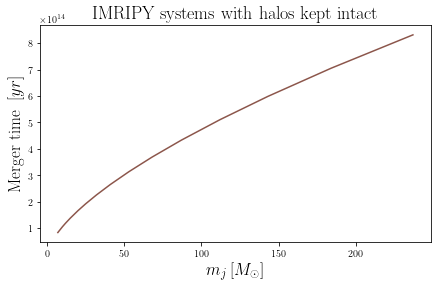

In [21]:
def final_merger_time_imripy(m_1):
    
    beta = 0.75
    gamma  =  0.65
    delta = -0.89
    a_i_ref = (1e4 * 0.04606)   # in units of pc
    m1_ref = 1      # in units of solar mass.
    m2_ref = 1e-3   # in units of solar mass.
    
    
    file = np.load('tmofj0.npz')
    ji_ref_list = file['arr_0']
    tm_ref_list = file['arr_1']
    

    def j_initial(m_1, m_2):
        return  (((85/3) * (G**3) * m_1 * m_2 * (m_1 + m_2) * t_m)/((a_i**4)*(c**5)))**(1/7)
    
    
    j_i = j_initial(m_1, m_2)
    
    
   # j_i_ref =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, k = 1) # j_i = factor_1 * g(t_m)
    
    
    
    tm_ref = InterpolatedUnivariateSpline(ji_ref_list, tm_ref_list, k = 2) # t_m = factor_2 * f(j_i)
    
  
   
    
    
    return tm_ref(j_i) * ((a_i / a_i_ref)**(beta)) * ((m_1/m1_ref)**(gamma)) * ((m_2 / m2_ref)**(delta))



final_merger_time_imripy_list = np.zeros(len(m_1_list))

for i, m_1 in enumerate(m_1_list):
    final_merger_time_imripy_list[i] = final_merger_time_imripy(m_1)


    
    
plt.figure(figsize=(7,4))    
    
plt.plot(m_1_list, final_merger_time_imripy_list, 'C5')
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('IMRIPY systems with halos kept intact', fontsize = 18)
plt.show()     

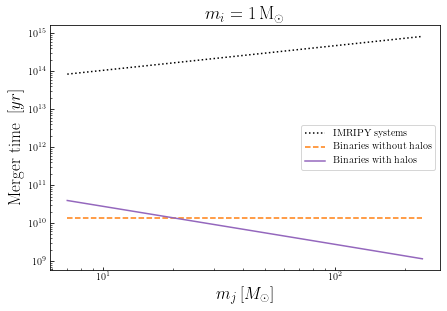

In [22]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(7,4.5))

plt.loglog(m_1_list, final_merger_time_imripy_list, 'k:')
plt.loglog(m_1_list, final_merger_time_nohalos_list, 'C1--')
plt.loglog(m_1_list, final_merger_time_withhalos_list, 'C4')




plt.legend([  "IMRIPY systems", "Binaries without halos", "Binaries with halos"], loc = 'center right')
plt.xlabel('$m_{j}\:[M_{\odot}]$', fontsize = 17)
plt.ylabel('Merger time $\: [yr]$', fontsize = 17)
plt.title('$m_{i} = 1 \, \mathrm{M_{\odot}}$', fontsize = 18)
plt.savefig('mergertime.pdf', bbox_inches = 'tight')
plt.show()  

In [16]:
file = np.load('tmofj0.npz')
ji_ref_list = file['arr_0']
tm_ref_list = file['arr_1']
print("ji_ref =", ji_ref_list)
print("tm_ref =", tm_ref_list, "yr")

ji_ref = [0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]
tm_ref = [6.59113844e+09 7.47401216e+09 8.14444114e+09 8.57827285e+09
 8.83919523e+09 9.06917563e+09 9.69862199e+09 1.20129929e+10
 1.98983463e+10 5.55056365e+10] yr
